# Dialogue Evaluation Tutorial

<p align="right" style="margin-right: 8px;">
    <a target="_blank" href="https://colab.research.google.com/github/idiap/sdialog/blob/main/tutorials/5.evaluation.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
</p>

In this tutorial, we'll evaluate LLM-generated dialogues against a real dataset (STAR). We'll:

- Set up the environment (Colab or local Jupyter) and install dependencies.
- Load the STAR dataset to serve as our reference.
- Load several model-generated dialogue sets to compare.
- Use an LLM-based judge to assess realism and collect feedback.
- Compute additional metrics (dialog flow perplexity, frequency of realism, turn-length stats, readability).
- Compare datasets side by side and visualize the results.

## Getting Started

### Environment setup

- Let's detect whether we're running on Google Colab or local Jupyter.
- On Colab, we'll sparsely check out only the `output` directory, install Ollama, and install `sdialog` in editable mode.
- On Jupyter, we'll use a small hack to avoid background process limitations so Ollama can run as a daemon.

In [ ]:
# Set up the environment depending on whether we are running in Google Colab or Jupyter Notebook
from IPython import get_ipython

if "google.colab" in str(get_ipython()):
    print("Running on Colab")

    # Download only the "output" directory from the repository
    !git init .
    !git remote add -f origin https://github.com/Play-Your-Part/tutorials.git
    !git config core.sparseCheckout true
    !echo "output" >> .git/info/sparse-checkout
    !git pull origin main

    # Install Ollama and needed packages
    !curl -fsSL https://ollama.com/install.sh | sh
    %pip install simpleneighbors

    # Install sdialog in editable mode
    !git clone https://github.com/idiap/sdialog.git
    %cd sdialog
    %pip install -e .
    %cd ..
else:
    print("Running in Jupyter Notebook")
    # Small hack to avoid "OSError: Background processes not supported." in classic Jupyter notebooks
    import os
    get_ipython().system = os.system

### Dataset

Let's clone the STAR dataset into `datasets/STAR`. After cloning, you should see the `dialogues` and `tasks` folders. STAR provides human-written conversations grouped by task names; we'll use it as our ground-truth reference for evaluation.

In [ ]:
# Let's clone the STAR dataset repository
!git clone https://github.com/RasaHQ/STAR.git datasets/STAR

# Let's check that `dialogues` and `tasks` folders are inside `datasets/STAR`
!ls datasets/STAR

### LLM backend and configuration

- Let's configure `sdialog` to use a local LLM served by Ollama and set the model to `qwen2.5:14b` (you can switch models if you prefer).
- We'll start the Ollama server in the background and give it a few seconds to initialize.
- We'll also point `sdialog.datasets.STAR` to the cloned dataset path so it can load dialogues.

In [ ]:
import sdialog

from sdialog.datasets import STAR

STAR.set_path("datasets/STAR/")

sdialog.config.llm("qwen2.5:14b")
# If you want to use another model, let's say OpenAI gpt-4, you can do, for instance:
# sdialog.config.llm("openai:gpt-4.1", api_key="YOUR_OPENAI_KEY")  # or set the key in the environment variable OPENAI_API_KEY

## Evaluation

### Evaluation overview

Here's what we'll do:
- Select a subset of STAR (our reference) dialogues to define the target distribution.
- Load multiple generated dialogue sets to compare (single-LLM, multi-agent, orchestration, and an outlier set).
- Inspect samples, then score dialogues with an LLM-based judge and other metrics.
- Aggregate results and compare datasets side by side.
- Visualize the comparison to understand strengths and weaknesses.

### Reference dialogues

Let's use the `doctor_followup` task with `happy=True` and `multitask=False` as our reference set. This gives us a focused domain and tone for evaluation—our generated dialogues will be compared against this distribution.

In [4]:
original_dialogs = STAR.get_dialogs(task_name="doctor_followup", happy=True, multitask=False)
print('Total number of happy "doctor_followup" dialogues:', len(original_dialogs))

Total number of happy "doctor_followup" dialogues: 105


### Model outputs to compare

We'll load several sets of generated dialogues:
- `single-llm`: produced by a single LLM.
- `multi-agents`: produced by a multi-agent setup.
- `multi-agents+orchestration`: multi-agent with orchestration.
- `outlier`: a deliberately different dataset (Primock-57) as an outlier.

We'll also normalize speaker names (e.g., `doctor`→`system`, `patient`→`user`) so all datasets share the same speaker labels for fair comparison—especially for metrics like `DialogFlowPPL` that consider speaker roles.

In [ ]:
from sdialog import Dialog

single_llm_dialogs = Dialog.from_file("output/STAR/full-generation/txt")
multi_agent_dialogs = Dialog.from_file("output/STAR/multi-agents/txt")
orche_dialogs = Dialog.from_file("output/STAR/multi-agents+orchestration/txt")
# Let's load Primock-57, our outlier dataset, directly from huggingface
outlier_dialogs = Dialog.from_huggingface("sdialog/Primock-57")
outlier_dialogs[:] = [d.rename_speaker("doctor", "system").rename_speaker("patient", "user")
                      for d in outlier_dialogs]

In [6]:
len(single_llm_dialogs)

105

### Inspect a sample dialogue

Let's print one dialogue to verify the structure (speaker turns, ordering, metadata) and content style. Make sure roles (`system`/`user`) and the flow align with expectations before running metrics.

In [7]:
single_llm_dialogs[0].print()

[dialog_id] 1
--- Dialogue Begins ---
[System] Hello, how can I help?
[User] Hi, could you please remind me of my doctor's instructions for the medicine?
[System] Could I get your name, please?
[User] My name is Alexis.
[System] Who is your doctor?
[User] I was seeing Dr. Morgan.
[System] Your instructions are: Take the medicine three times a day, 30 minutes before meals.
[User] Thank you, that's helpful.
[System] Is there anything else that I can do for you?
[User] No, that's all. Thank you.
[System] Thank you and goodbye.
--- Dialogue Ends ---


### LLM-based realism judge

`LLMJudgeRealDialog` prompts an LLM to assess whether a dialogue resembles a real human conversation for the given domain. It can return a judgment and optional textual feedback explaining the decision. Below, we'll try single-dialog evaluation with and without feedback, and then apply the same judge to other datasets.

In [ ]:
from sdialog.evaluation import LLMJudgeRealDialog

judge_real = LLMJudgeRealDialog()

By default, calling the object returns the verdict as a score (1 or 0):

In [9]:
judge_real(single_llm_dialogs[0])

0

Alternatively, we can use the `judge()` method to get an object with two attributes:

In [10]:
verdict = judge_real.judge(single_llm_dialogs[0])

print("Real dialog?", verdict.positive)
print("Reason:", verdict.reason)

Real dialog? False
Reason: None


We can call the judge method with `reason=True` to populate the `reason` field with the LLM's explanation:

In [11]:
verdict = judge_real.judge(single_llm_dialogs[0], reason=True)

print("Real dialog?", verdict.positive)
print("Reason:", verdict.reason)

Real dialog? False
Reason: The dialogue lacks sufficient depth, natural flow, and contextual richness to be considered a real human conversation. The exchange is short and trivial with no evidence of genuine intent, emotion, or subtlety in interaction. Additionally, the System's responses are too generic and repetitive, resembling an automated response system rather than a human interaction.


### Frequency of realism

`FrequencyEvaluator` uses the judge to compute how often dialogues are classified as "real" within a set. Let's compare values across datasets; closer to the reference distribution usually indicates better realism for the target task.

_(Tip: enable the cache so repeated runs reuse previous LLM judgments.)_

In [12]:
sdialog.config.cache(True)

[2025-10-15 16:43:37] INFO:sdialog.config:Caching enabled. Cache path: ~/.sdialog/
[2025-10-15 16:43:37] WARNING:sdialog.config:Caution: Caching may cause outdated results if external or implicit variables affecting score computation are changed. For example, if you use LLMJudge-based scores without specifying the model (relying on the global default), the cache will return previous results even if the default model changes. To avoid inconsistencies, ensure all relevant parameters are explicitly set when caching is enabled.
Use with caution! ;)


In [13]:
from sdialog.evaluation import FrequencyEvaluator

judge_real = LLMJudgeRealDialog(reason=True)  # Let's create the judge again with reason enabled by default

freq_real = FrequencyEvaluator(judge_real)

freq_real(single_llm_dialogs[:10])

[2025-10-15 16:43:38] INFO:sdialog.util:Loading Ollama model: qwen2.5:14b


0.0

0% of the first 10 dialogs were judged as real. Let's check our outlier dataset:

In [14]:
freq_real(outlier_dialogs[:10])

0.9

In contrast, 90% of the first 10 dialogs were judged as real.

### Custom metrics

Let's define a simple score to count the number of turns in a dialogue, called `DialogLength`: 

In [15]:
from sdialog.evaluation import BaseDialogScore

# Let's define a new dialog score to count the number of turns in a dialog 
class DialogLength(BaseDialogScore):
    def score(self, dialog: Dialog) -> int:
        return len(dialog)

Let's test it with the first dialog from the `single_llm_dialogs` list:

In [16]:
dialog_len = DialogLength()

print("The dialog length is:", dialog_len(single_llm_dialogs[0]))

The dialog length is: 11


We can also compute readability-related linguistic features—for example, the Gunning Fog index for a given dialogue:

In [17]:
from sdialog.evaluation import LinguisticFeatureScore

gunning_fog = LinguisticFeatureScore(feature="gunning-fog")

print(f"Index for the First single llm dialog: {gunning_fog(single_llm_dialogs[0]):.1f}")
print(f"Index for the First orchestrated multi-agent dialog: {gunning_fog(orche_dialogs[0]):.1f}")

Index for the First single llm dialog: 6.4
Index for the First orchestrated multi-agent dialog: 8.0


We can see that the single-LLM dialogue uses simpler language, with a readability score nearly two levels lower than the dialogue produced by the orchestrated multi-agent approach.

### Configuring the dataset comparator

We assemble several evaluators:
- `FrequencyEvaluator(LLMJudgeRealDialog)`: fraction of dialogues judged as realistic.
- `StatsEvaluator(DialogLength)`: summarizes dialog length stats.
- `MeanEvaluator(LinguisticFeatureScore)`: readability indicators.
- `ReferenceCentroidEmbeddingEvaluator(SentenceTransformerDialogEmbedder)`: centroid-based distances.

In [18]:
import sdialog

from sdialog.evaluation import DatasetComparator
from sdialog.evaluation import LLMJudgeRealDialog, LinguisticFeatureScore
from sdialog.evaluation import StatsEvaluator, FrequencyEvaluator, MeanEvaluator

from sdialog.evaluation import ReferenceCentroidEmbeddingEvaluator
from sdialog.evaluation import SentenceTransformerDialogEmbedder

# Let's make sure the cache is enabled
sdialog.config.cache(True)

# We will also measure the distance between the embeddings of the generated dialogs and the original ones
# Let's create the default dialog embedder
dialog_embedder = SentenceTransformerDialogEmbedder("sentence-transformers/LaBSE")

real_dialog_judge = LLMJudgeRealDialog(reason=True)  # LLM-as-Judge
dialog_length = DialogLength(name="turn length")  # Our own dialog length
linguistic_features = LinguisticFeatureScore(feature=["flesch-reading-ease", "gunning-fog"]) # Two linguistic features

comparator = DatasetComparator(
    evaluators=[
        FrequencyEvaluator(real_dialog_judge, name="Real dialog frequency"),  # Frequency of "real dialogs" according to the LLM judge
        StatsEvaluator(dialog_length, stat="median", name="Mean length"),  # Median of the dialog lengths
        MeanEvaluator(linguistic_features),  # Mean of the linguistic features
        ReferenceCentroidEmbeddingEvaluator(dialog_embedder, original_dialogs, name="Mean centroid similarity")  # Centroid-based Embedding similarity to original dialogs
    ]
)

[2025-10-15 16:44:09] INFO:sdialog.config:Caching enabled. Cache path: ~/.sdialog/
[2025-10-15 16:44:09] WARNING:sdialog.config:Caution: Caching may cause outdated results if external or implicit variables affecting score computation are changed. For example, if you use LLMJudge-based scores without specifying the model (relying on the global default), the cache will return previous results even if the default model changes. To avoid inconsistencies, ensure all relevant parameters are explicitly set when caching is enabled.
Use with caution! ;)
[2025-10-15 16:44:09] INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
[2025-10-15 16:44:09] INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/LaBSE
[2025-10-15 16:44:13] INFO:sdialog.util:Loading Ollama model: qwen2.5:14b


### Running the comparison

The comparator expects a dictionary mapping labels to lists of `Dialog` objects. Include a `reference` key for the ground-truth set. The output aggregates all evaluator results so you can quickly spot which generated datasets best match the reference.

_(NOTE: We only use the first 20 dialogs of each set to speedup the process since LLM-as-Judge takes some time, if you have more time, you can run the comparison on all of them)_

In [19]:
result = comparator({
    "reference": original_dialogs[:20],
    "single-llm": single_llm_dialogs[:20],
    "multi-agents": multi_agent_dialogs[:20],
    "multi-agents+orchestration": orche_dialogs[:20],
    "outlier": outlier_dialogs[:20]
})

| dataset                    |   Real dialog frequency |   Mean length |   mean-gunning_fog |   mean-flesch_reading_ease |   Mean centroid similarity |
|:---------------------------|------------------------:|--------------:|-------------------:|---------------------------:|---------------------------:|
| reference                  |                    0.05 |          8.00 |               7.59 |                      70.82 |                       1.00 |
| single-llm                 |                    0.00 |          9.50 |               6.83 |                      72.60 |                       0.94 |
| multi-agents               |                    0.45 |          9.00 |               8.74 |                      68.69 |                       0.84 |
| multi-agents+orchestration |                    0.35 |          9.00 |               8.32 |                      71.13 |                       0.85 |
| outlier                    |                    0.95 |        129.00 |               6

### Visualizing results

`comparator.plot()` charts each metric across datasets. Look for:
- Higher frequency of realism (when appropriate)
- Reasonable dialogue lengths relative to reference
- Readability scores in a plausible range for the task
- t-SNE plots of dialog embeddings

These views help diagnose which generation strategies perform best and where they diverge.

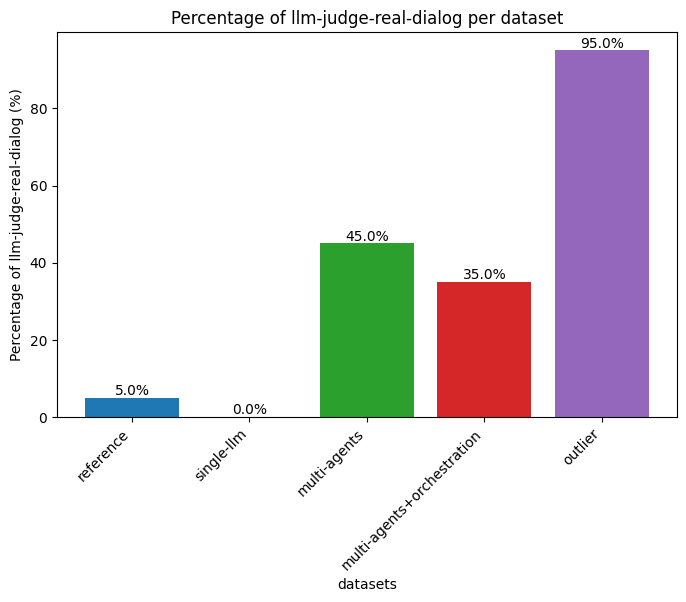

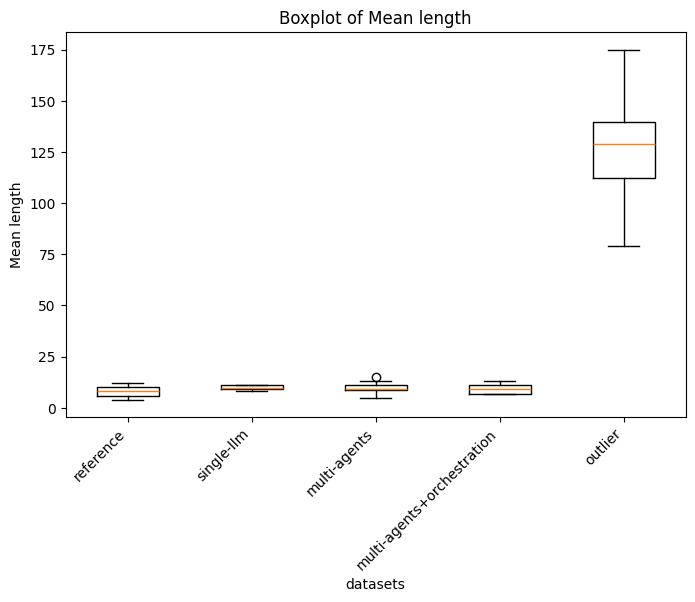

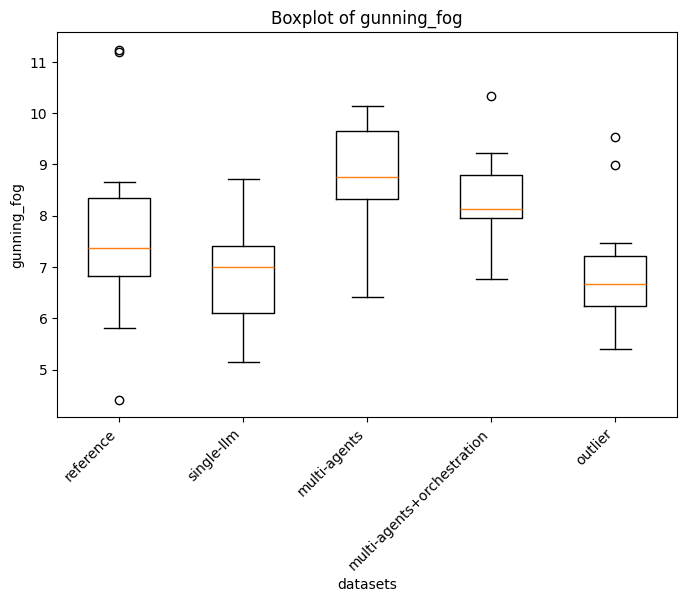

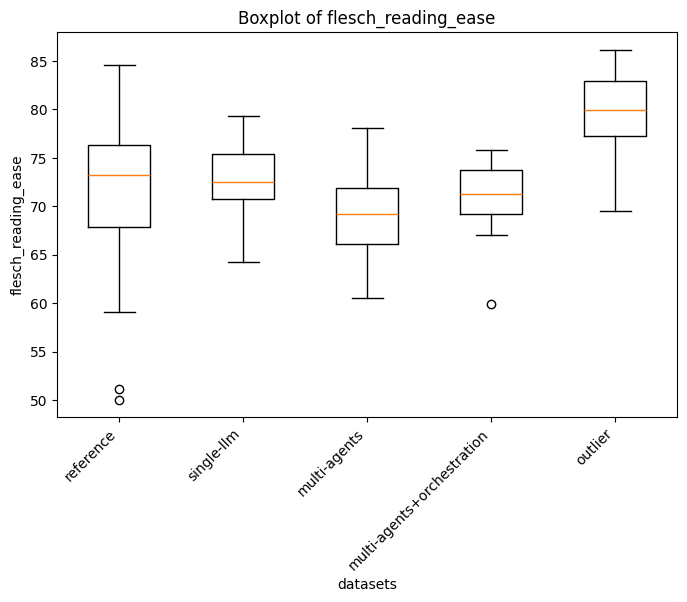

[2025-10-15 16:44:58] INFO:sdialog.evaluation:Computing t-SNE for embeddings...


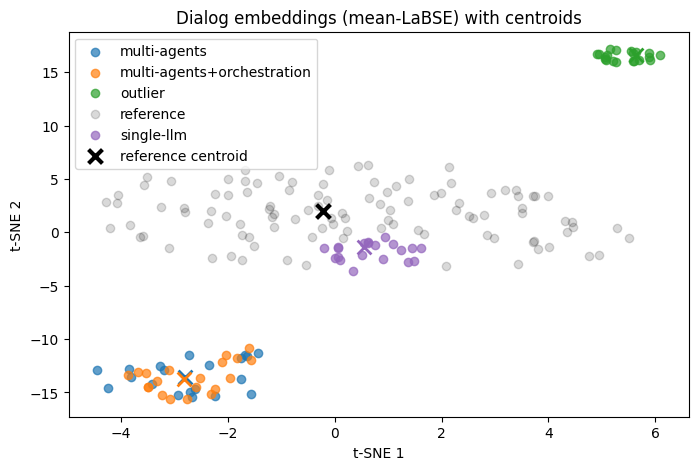

In [20]:
comparator.plot()